# Notebook for CML processing and testing

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import tqdm
import xarray as xr
import pandas as pd
import contextily as cx

import benchmarks.processing.baseline as baseline
import benchmarks.processing.wet_antenna as wet_antenna
import benchmarks.processing.k_R_relation as KR
import benchmarks.processing.spatial.interpolator as interpolator

from utils.load import get_gauge_coordinate_mappings, load_raingauge_dataset
from scipy.stats import pearsonr, spearmanr
from utils.visualisation import *

/opt/miniconda3/envs/fyp/lib/python3.13/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [4]:
data_path = ""
cmls = xr.open_dataset("database/cml_data_processed_2025.nc")
print(cmls.coords)

Coordinates:
  * time              (time) datetime64[ns] 68kB 2025-02-01 ... 2025-04-30
  * station           (station) <U9 72B 'Station A' 'Station B'
    resource_name     (link_id, station) <U81 268kB ...
    site_a_latitude   (link_id) float64 3kB ...
    site_a_longitude  (link_id) float64 3kB ...
    site_b_latitude   (link_id) float64 3kB ...
    site_b_longitude  (link_id) float64 3kB ...
    frequency         (link_id) float64 3kB ...
    polarization      (link_id) <U2 3kB ...
    length            (link_id) float64 3kB ...
    source_site_id    (link_id) <U12 20kB ...
    sink_site_id      (link_id) <U13 22kB ...
  * link_id           (link_id) <U40 66kB 'AMK_1012_1655_59-ODU_25-ODU' ... '...


In [5]:
cml_list = [cmls.sel(link_id=i) for i in cmls["link_id"]]
print(cml_list)

[<xarray.Dataset> Size: 2MB
Dimensions:           (station: 2, time: 8444)
Coordinates: (12/13)
  * time              (time) datetime64[ns] 68kB 2025-02-01 ... 2025-04-30
  * station           (station) <U9 72B 'Station A' 'Station B'
    resource_name     (station) <U81 648B ...
    site_a_latitude   float64 8B ...
    site_a_longitude  float64 8B ...
    site_b_latitude   float64 8B ...
    ...                ...
    frequency         float64 8B ...
    polarization      <U2 8B ...
    length            float64 8B ...
    source_site_id    <U12 48B ...
    sink_site_id      <U13 52B ...
    link_id           <U40 160B 'AMK_1012_1655_59-ODU_25-ODU'
Data variables: (12/14)
    RSL_MAX           (station, time) float64 135kB ...
    RSL_MIN           (station, time) float64 135kB ...
    RSL_AVG           (station, time) float64 135kB ...
    RSL_CUR           (station, time) float64 135kB ...
    TSL_MAX           (station, time) float64 135kB ...
    TSL_MIN           (station, time) 

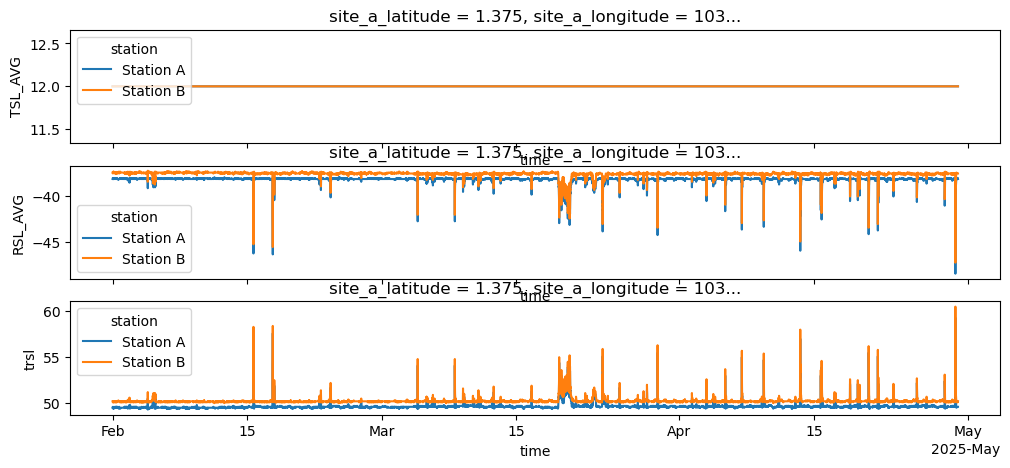

In [6]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(12,5))
cml_list[0].TSL_AVG.plot.line(x='time', ax=ax[0])
cml_list[0].RSL_AVG.plot.line(x='time', ax=ax[1])
cml_list[0].trsl.plot.line(x='time', ax=ax[2])

In [7]:
cml = cml_list[0].copy()
threshold = 0.8

roll_std_dev = cml.trsl.rolling(time=60, center=True).std()
cml['wet_2'] = cml.trsl.rolling(time=60, center=True).std() > threshold

print(cml['wet'].values)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Text(0.5, 1.0, '')

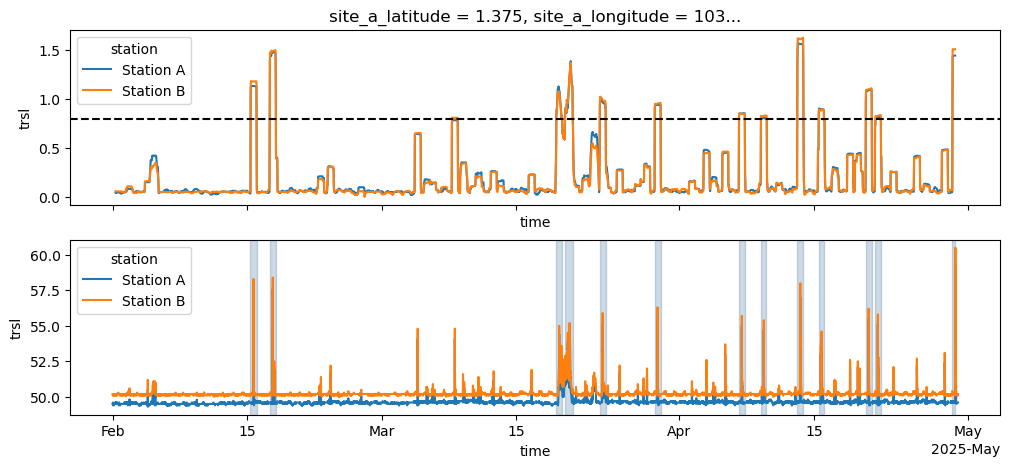

In [8]:
fig, ax = plt.subplots(2,1, figsize=(12,5), sharex=True)

roll_std_dev.plot.line(x='time', ax=ax[0])
ax[0].axhline(threshold, color='k', linestyle='--')
cml.trsl.plot.line(x='time', ax=ax[1])

wet_start = np.roll(cml.wet_2, -1) & ~cml.wet_2
wet_end = np.roll(cml.wet_2, 1) & ~cml.wet_2

for wet_start_i, wet_end_i in zip(
    wet_start.values[0].nonzero()[0], #values[0] is station A, values[1] is station B
    wet_end.values[0].nonzero()[0],
):
     ax[1].axvspan(cml.time.values[wet_start_i], cml.time.values[wet_end_i], color='b', alpha=0.1)

     ax[1].axvspan(cml.time.values[wet_start_i], cml.time.values[wet_end_i], color='g', alpha=0.1)

ax[1].set_title('')

Text(0, 0.5, 'TRSL')

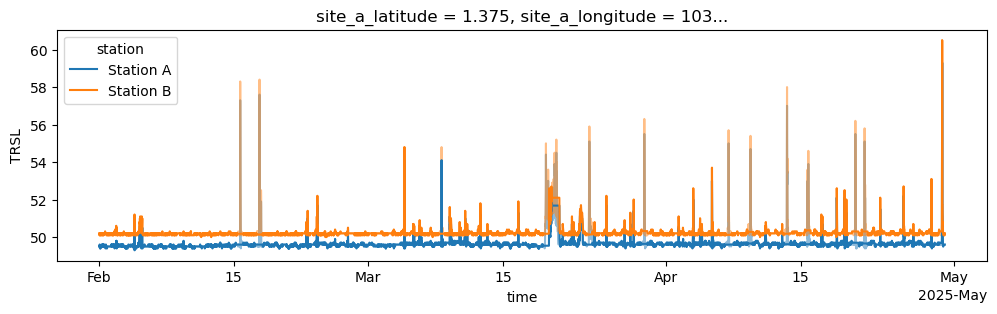

In [9]:
cml['baseline'] = baseline.baseline_constant(trsl=cml.trsl, wet=cml.wet_2, n_average_last_dry=5)

fig, ax = plt.subplots(figsize=(12,3))

cml.trsl.plot.line(x='time', alpha=0.5)
plt.gca().set_prop_cycle(None)
cml.baseline.plot.line(x='time')
plt.gca().set_prop_cycle(None)
plt.ylabel('TRSL')

In [10]:
cml['waa'] = wet_antenna.waa_schleiss_2013(
    rsl=cml.trsl, 
    baseline=cml.baseline, 
    wet=cml.wet, 
    waa_max=2.2, 
    delta_t=1, 
    tau=15,
)

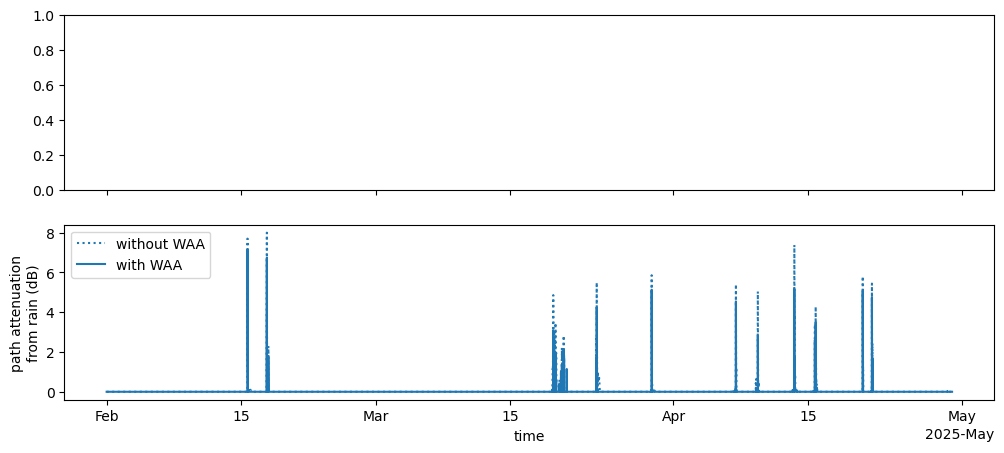

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(12,5), sharex=True)

# plt.sca(axs[0])
# cml.isel(channel_id=0).trsl.plot.line(x='time', alpha=0.5, label='TRSL')
# plt.gca().set_prop_cycle(None)
# cml.isel(channel_id=0).baseline.plot.line(x='time', linestyle=':', label='baseline without WAA');
# plt.gca().set_prop_cycle(None)
# (cml.baseline + cml.waa).isel(channel_id=0).plot.line(x='time', label='baseline with WAA');
# plt.ylabel('TRSL (dB)')
# axs[0].legend()

# estimate WAA and correct baseline
cml['A'] = cml.trsl - cml.baseline - cml.waa
cml['A'].values[cml.A < 0] = 0
cml['A_no_waa_correct'] = cml.trsl - cml.baseline
cml['A_no_waa_correct'].values[cml.A_no_waa_correct < 0] = 0 

plt.sca(axs[1])
cml.A_no_waa_correct.sel(station=cml.station[0]).plot.line(x='time', linestyle=':', label='without WAA');
plt.gca().set_prop_cycle(None)
cml.A.sel(station=cml.station[0]).plot.line(x='time', label='with WAA');
plt.ylabel('path attenuation\nfrom rain (dB)');
axs[1].set_title('');
axs[1].legend()


In [12]:
print(cml.frequency)
cml['R'] = KR.calc_R_from_A(A=cml.A, L_km=float(cml.length), f_GHz=cml.frequency, pol=cml.polarization)

<xarray.DataArray 'frequency' ()> Size: 8B
array(23.)
Coordinates:
    site_a_latitude   float64 8B 1.375
    site_a_longitude  float64 8B 103.8
    site_b_latitude   float64 8B 1.376
    site_b_longitude  float64 8B 103.8
    frequency         float64 8B 23.0
    polarization      <U2 8B 'V'
    length            float64 8B 0.49
    source_site_id    <U12 48B '1012'
    sink_site_id      <U13 52B '1655'
    link_id           <U40 160B 'AMK_1012_1655_59-ODU_25-ODU'


Text(0.5, 1.0, '')

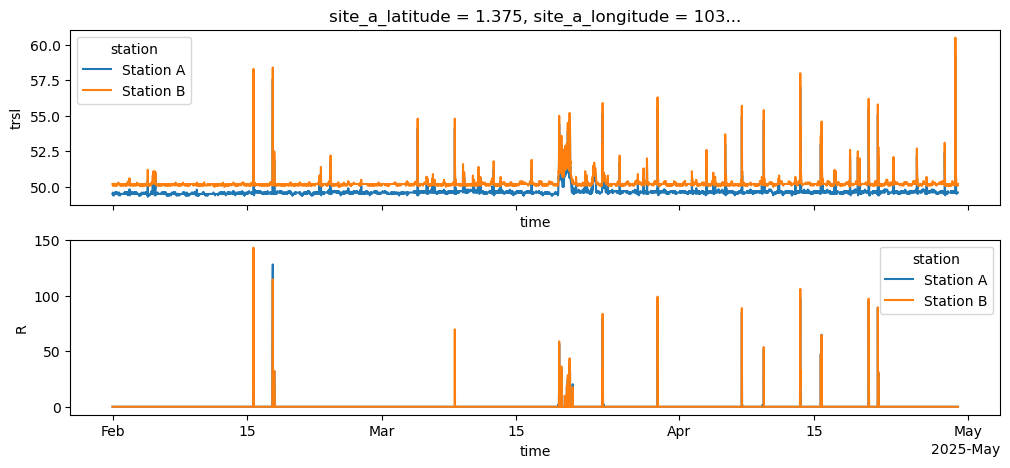

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(12,5), sharex=True)
cml.trsl.plot.line(x='time', ax=axs[0])
cml.R.plot.line(x='time', ax=axs[1])
axs[1].set_title('')

In [14]:
for cml in tqdm.tqdm(cml_list):
    cml['wet'] = cml.trsl.rolling(time=60, center=True).std(skipna=False) > 0.8
    
    cml['wet_fraction'] = (cml.wet==1).sum() / len(cml.time)
    
    cml['baseline'] = baseline.baseline_constant(
        trsl=cml.trsl, 
        wet=cml.wet, 
        n_average_last_dry=5,
    )
    cml['waa'] = wet_antenna.waa_schleiss_2013(
        rsl=cml.trsl, 
        baseline=cml.baseline, 
        wet=cml.wet, 
        waa_max=2.2, 
        delta_t=1, 
        tau=15,
    )
    cml['A'] = cml.trsl - cml.baseline - cml.waa
    
    # Note that we set A < 0 to 0 here, but it is not strictly required for 
    # the next step, because calc_R_from_A sets all rainfall rates below 
    # a certain threshold (default is 0.1) to 0. Some people might want to
    # keep A as it is to check later if there were negative numbers.
    cml['A'].values[cml.A < 0] = 0
    
    if (cml.polarization=='HV'):
      cml['R'] = KR.calc_R_from_A(
          A=cml.A, L_km=float(cml.length), f_GHz=cml.frequency, pol='V'
    ) 
    else :
      cml['R'] = KR.calc_R_from_A(
          A=cml.A, L_km=float(cml.length), f_GHz=cml.frequency, pol=cml.polarization
    )

100%|██████████| 414/414 [00:05<00:00, 79.87it/s]


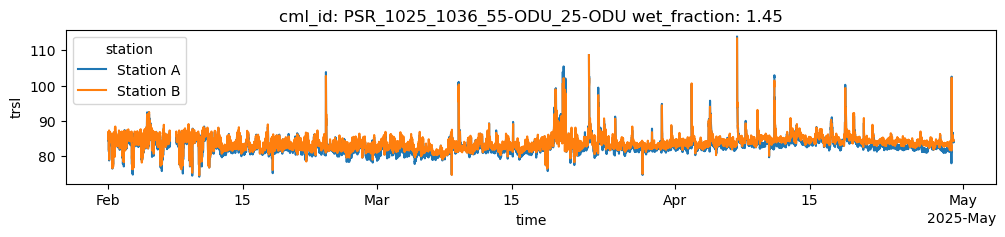

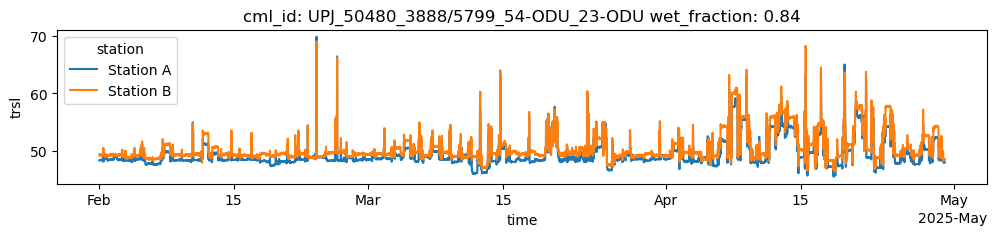

In [15]:
for cml in cml_list:
    if cml.wet_fraction > 0.8:
        cml.trsl.plot.line(x='time', figsize=(12,2))
        plt.title(f'cml_id: {cml.link_id.values} wet_fraction: {cml.wet_fraction.values:0.2f}')
        plt.show()

<xarray.DataArray 'R' (time: 8444)> Size: 68kB
array([0., 0., 0., ..., 0., 0., 0.], shape=(8444,))
Coordinates: (12/13)
  * time              (time) datetime64[ns] 68kB 2025-02-01 ... 2025-04-30
    station           <U9 36B 'Station A'
    resource_name     <U81 324B '1012-980-01 Ang Mo Kio Ave 4 Blk 171-59-ODU-...
    site_a_latitude   float64 8B 1.375
    site_a_longitude  float64 8B 103.8
    site_b_latitude   float64 8B 1.376
    ...                ...
    frequency         float64 8B 23.0
    polarization      <U2 8B 'V'
    length            float64 8B 0.49
    source_site_id    <U12 48B '1012'
    sink_site_id      <U13 52B '1655'
    link_id           <U40 160B 'AMK_1012_1655_59-ODU_25-ODU'


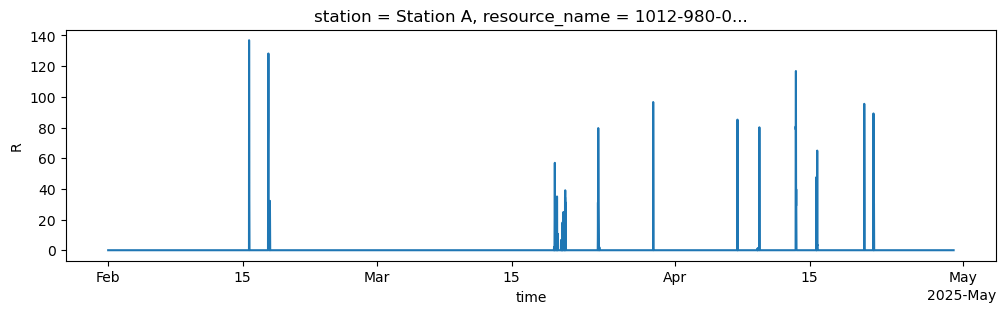

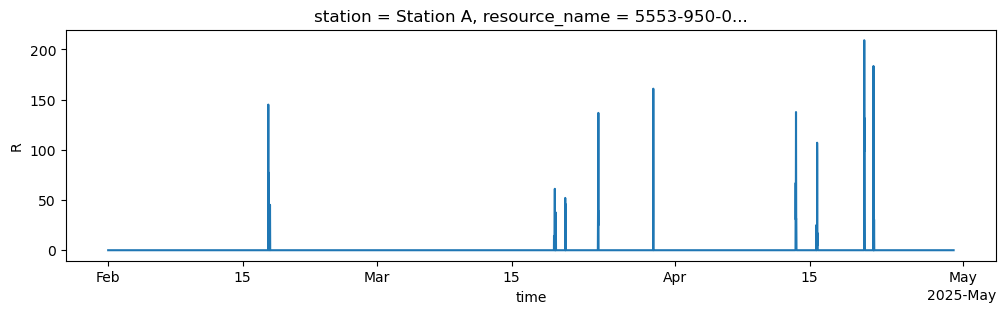

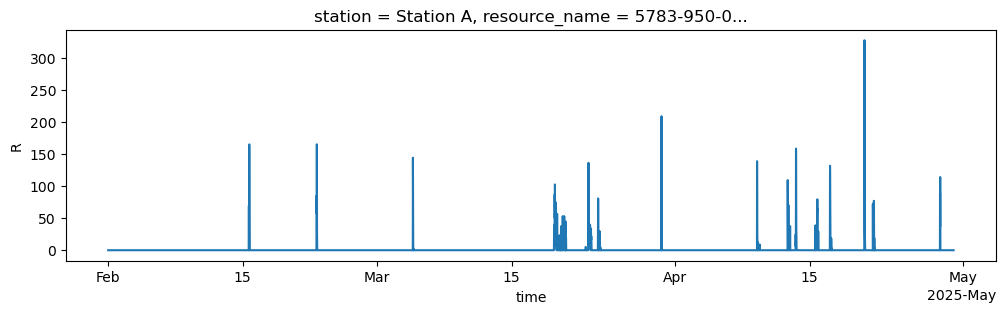

In [16]:
print(cml_list[0].sel(station='Station A').R)
for i in [0, 12, 57]:
  (cml_list[i].sel(station='Station A').R).plot(
      x='time', label='CML', color='C0', figsize=(12, 3)
  )
  

In [17]:
ds_cmls = xr.concat(cml_list, dim='link_id')

In [18]:
print(ds_cmls)

<xarray.Dataset> Size: 735MB
Dimensions:           (link_id: 414, station: 2, time: 8444)
Coordinates: (12/13)
  * time              (time) datetime64[ns] 68kB 2025-02-01 ... 2025-04-30
  * station           (station) <U9 72B 'Station A' 'Station B'
    resource_name     (link_id, station) <U81 268kB '1012-980-01 Ang Mo Kio A...
    site_a_latitude   (link_id) float64 3kB 1.375 1.372 1.372 ... 1.347 1.347
    site_a_longitude  (link_id) float64 3kB 103.8 103.9 103.9 ... 103.9 103.9
    site_b_latitude   (link_id) float64 3kB 1.376 1.367 1.367 ... 1.35 1.35 1.35
    ...                ...
    frequency         (link_id) float64 3kB 23.0 18.0 18.0 ... 23.0 23.0 23.0
    polarization      (link_id) <U2 3kB 'V' 'HV' 'HV' 'HV' ... 'HV' 'HV' 'HV'
    length            (link_id) float64 3kB 0.49 1.3 1.3 1.3 ... 0.73 0.73 0.73
    source_site_id    (link_id) <U12 20kB '1012' '1064' '1064' ... '5497' '5497'
    sink_site_id      (link_id) <U13 22kB '1655' 'AMK271B' ... '5180' '5180'
  * link_id

In [19]:
cmls_R_15min = ds_cmls.R.resample(time='15min', label='right').mean().to_dataset()
print(cmls_R_15min)

<xarray.Dataset> Size: 56MB
Dimensions:           (station: 2, link_id: 414, time: 8449)
Coordinates: (12/13)
  * station           (station) <U9 72B 'Station A' 'Station B'
  * link_id           (link_id) <U40 66kB 'AMK_1012_1655_59-ODU_25-ODU' ... '...
  * time              (time) datetime64[ns] 68kB 2025-02-01T00:15:00 ... 2025...
    resource_name     (link_id, station) <U81 268kB '1012-980-01 Ang Mo Kio A...
    site_a_latitude   (link_id) float64 3kB 1.375 1.372 1.372 ... 1.347 1.347
    site_a_longitude  (link_id) float64 3kB 103.8 103.9 103.9 ... 103.9 103.9
    ...                ...
    site_b_longitude  (link_id) float64 3kB 103.8 103.9 103.9 ... 103.9 103.9
    frequency         (link_id) float64 3kB 23.0 18.0 18.0 ... 23.0 23.0 23.0
    polarization      (link_id) <U2 3kB 'V' 'HV' 'HV' 'HV' ... 'HV' 'HV' 'HV'
    length            (link_id) float64 3kB 0.49 1.3 1.3 1.3 ... 0.73 0.73 0.73
    source_site_id    (link_id) <U12 20kB '1012' '1064' '1064' ... '5497' '5497'
    s

In [20]:
cmls_R_15min['lat_center'] = (cmls_R_15min.site_a_latitude + cmls_R_15min.site_b_latitude)/2
cmls_R_15min['lon_center'] = (cmls_R_15min.site_a_longitude + cmls_R_15min.site_b_longitude)/2

In [21]:
idw_interpolator = interpolator.IdwKdtreeInterpolator(
  nnear=15,
  p=2,
  exclude_nan=True,
  max_distance = 100000,
)

In [22]:
# print(cmls_R_1h.R.sel(link_id=cmls['link_id'][0]).sum(dim='time').where(ds_cmls.wet_fraction < 0.3))
print(cmls_R_15min.lat_center)

<xarray.DataArray 'lat_center' (link_id: 414)> Size: 3kB
array([1.37543056, 1.36943056, 1.36943056, 1.36943056, 1.36943056,
       1.36831944, 1.36673611, 1.36673611, 1.35269444, 1.35269444,
       1.35269444, 1.35269444, 1.35355556, 1.35511111, 1.35511111,
       1.37573611, 1.35136111, 1.37023611, 1.38522222, 1.38522222,
       1.38522222, 1.33825   , 1.34275   , 1.34275   , 1.34275   ,
       1.34275   , 1.37093056, 1.37211111, 1.37481944, 1.35908333,
       1.361     , 1.35934722, 1.376375  , 1.376375  , 1.376375  ,
       1.376375  , 1.37854167, 1.37933333, 1.38115278, 1.38115278,
       1.371625  , 1.36475   , 1.37011111, 1.38893056, 1.36636111,
       1.36452778, 1.39715278, 1.36859722, 1.36005556, 1.36068056,
       1.36270833, 1.31968056, 1.31513889, 1.31513889, 1.27870833,
       1.31113889, 1.31113889, 1.30365278, 1.30365278, 1.277375  ,
       1.31593056, 1.31593056, 1.340375  , 1.31065278, 1.31644444,
       1.33552778, 1.31933333, 1.32765278, 1.34522222, 1.34520833,
     

In [23]:
print(cmls_R_15min.R.sel(link_id=cmls['link_id'][0]).sum(dim='time').where(ds_cmls.wet_fraction < 0.3))

<xarray.DataArray 'R' (station: 2, link_id: 414)> Size: 7kB
array([[2830.48984976,           nan,           nan,           nan,
                  nan, 2830.48984976, 2830.48984976, 2830.48984976,
        2830.48984976, 2830.48984976, 2830.48984976, 2830.48984976,
        2830.48984976, 2830.48984976,           nan, 2830.48984976,
        2830.48984976, 2830.48984976,           nan, 2830.48984976,
                  nan, 2830.48984976, 2830.48984976, 2830.48984976,
        2830.48984976, 2830.48984976, 2830.48984976,           nan,
        2830.48984976, 2830.48984976, 2830.48984976, 2830.48984976,
                  nan,           nan,           nan,           nan,
        2830.48984976, 2830.48984976,           nan,           nan,
        2830.48984976, 2830.48984976, 2830.48984976, 2830.48984976,
        2830.48984976, 2830.48984976,           nan, 2830.48984976,
        2830.48984976, 2830.48984976,           nan,           nan,
                  nan,           nan, 2830.48984976,    

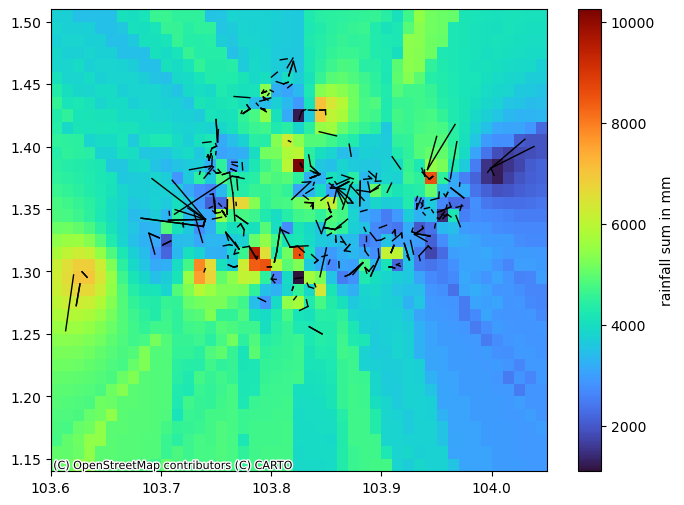

In [75]:
def plot_cml_lines(ds_cml, ax, visualise_station=False):
  ax.plot(
    [ds_cmls.site_a_longitude, ds_cmls.site_b_longitude],
    [ds_cmls.site_a_latitude, ds_cmls.site_b_latitude],
    'k',
    linewidth=1,
  )
  if visualise_station:
    ax.scatter(ds_cmls.site_a_longitude, ds_cmls.site_a_latitude, color='red', s=12)
    ax.scatter(ds_cmls.site_b_longitude, ds_cmls.site_b_latitude, color='red', s=12)

xcoords= np.arange(103.605, 104.05, 0.01)
ycoords= np.arange(1.145, 1.51, 0.01)
ycoords=ycoords[::-1]
xgrid, ygrid = np.meshgrid(xcoords, ycoords)

R_grid = idw_interpolator(
  x=cmls_R_15min.lon_center,
  y=cmls_R_15min.lat_center,
  z=cmls_R_15min.R.sel(station='Station A').sum(dim='time').where(ds_cmls.wet_fraction < 0.3),
  xgrid=xgrid,
  ygrid=ygrid,
  resolution=0.01,
)

bounds = np.arange(0, 80, 5.0)
bounds[0] = 1
norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')

fig, ax = plt.subplots(figsize=(8,6))
pc = plt.pcolormesh(
  idw_interpolator.xgrid,
  idw_interpolator.ygrid,
  R_grid,
  shading='nearest',
  cmap='turbo',
  #norm=norm,
)
cx.add_basemap(ax=ax, crs=4326, source=cx.providers.CartoDB.Voyager)

plot_cml_lines(cmls_R_15min, ax=ax)
fig.colorbar(pc, label="rainfall sum in mm")

In [51]:
print(len(set(cmls_R_15min.site_a_latitude.values)))

213


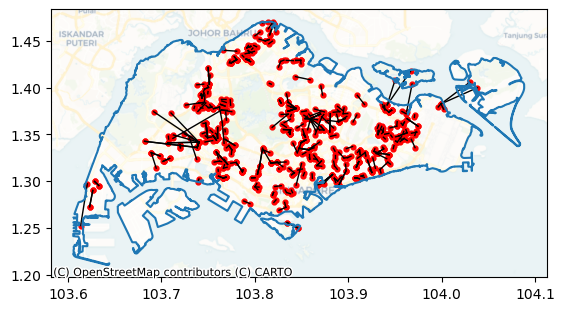

In [76]:
from utils.visualisation import visualise_with_basemap, visualise_singapore_outline
fig, ax = plt.subplots()
plot_cml_lines(cmls_R_15min, ax=ax, visualise_station=True)
visualise_singapore_outline(ax=ax)
visualise_with_basemap(ax=ax)

In [39]:
print(len(cmls_R_15min.site_a_latitude))

414


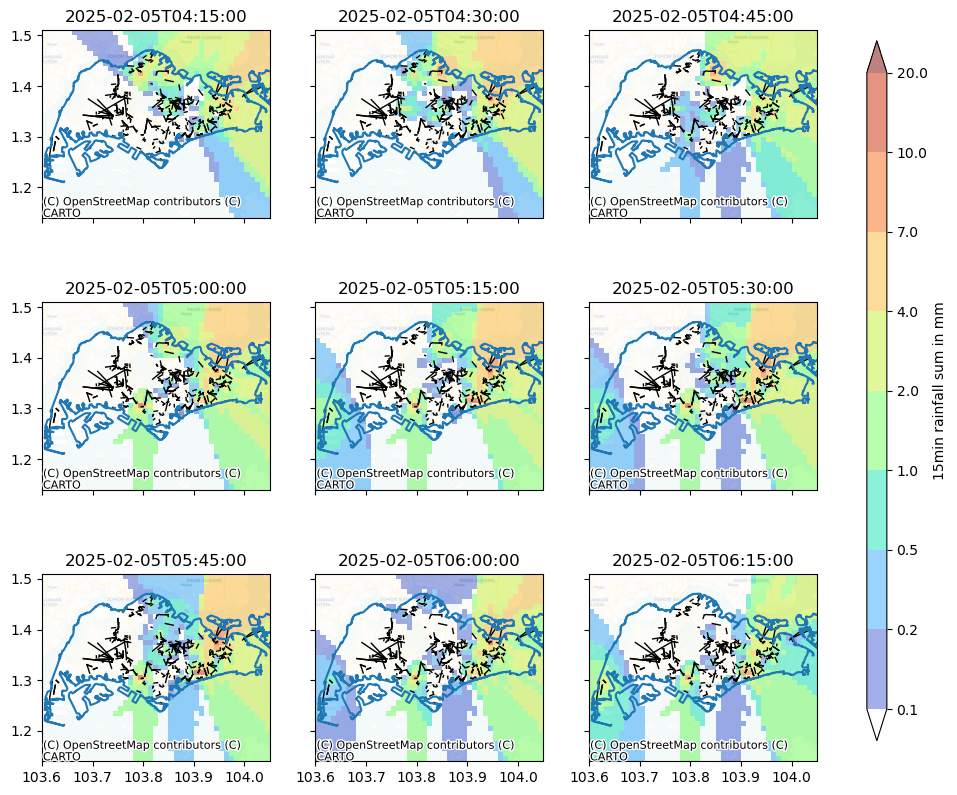

In [25]:
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(10, 10))

bounds = [0.1, 0.2, 0.5, 1, 2, 4, 7, 10, 20] 
norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')
cmap = plt.get_cmap('turbo').copy()
cmap.set_under('w')


for i, axi in enumerate(ax.flat):
    R_grid = idw_interpolator(
        x=cmls_R_15min.lon_center, 
        y=cmls_R_15min.lat_center, 
        z=cmls_R_15min.R.sel(station='Station A').isel(time=i + 400).where(ds_cmls.wet_fraction < 0.3), 
        xgrid=xgrid,
        ygrid=ygrid,
        resolution=0.01,
    )
    pc = axi.pcolormesh(
        idw_interpolator.xgrid, 
        idw_interpolator.ygrid, 
        R_grid, 
        shading='nearest', 
        cmap=cmap,
        norm=norm,
        alpha=0.5
    )
    axi.set_title(str(cmls_R_15min.time.values[i + 400])[:19])
    visualise_with_basemap(axi)
    plot_cml_lines(cmls_R_15min, ax=axi)
    visualise_singapore_outline(ax=axi)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cb = fig.colorbar(pc, cax=cbar_ax, label='15min rainfall sum in mm', )

In [26]:
print(idw_interpolator.xgrid)
print(idw_interpolator.ygrid)

[[103.605 103.615 103.625 ... 104.025 104.035 104.045]
 [103.605 103.615 103.625 ... 104.025 104.035 104.045]
 [103.605 103.615 103.625 ... 104.025 104.035 104.045]
 ...
 [103.605 103.615 103.625 ... 104.025 104.035 104.045]
 [103.605 103.615 103.625 ... 104.025 104.035 104.045]
 [103.605 103.615 103.625 ... 104.025 104.035 104.045]]
[[1.505 1.505 1.505 ... 1.505 1.505 1.505]
 [1.495 1.495 1.495 ... 1.495 1.495 1.495]
 [1.485 1.485 1.485 ... 1.485 1.485 1.485]
 ...
 [1.165 1.165 1.165 ... 1.165 1.165 1.165]
 [1.155 1.155 1.155 ... 1.155 1.155 1.155]
 [1.145 1.145 1.145 ... 1.145 1.145 1.145]]


In [27]:
raingauge_df = load_raingauge_dataset('rainfall_data.csv', N=0)
station_dict = get_gauge_coordinate_mappings()

print(raingauge_df.shape)

(26096, 63)


In [28]:
print(xgrid)
print(ygrid)

print

[[103.605 103.615 103.625 ... 104.025 104.035 104.045]
 [103.605 103.615 103.625 ... 104.025 104.035 104.045]
 [103.605 103.615 103.625 ... 104.025 104.035 104.045]
 ...
 [103.605 103.615 103.625 ... 104.025 104.035 104.045]
 [103.605 103.615 103.625 ... 104.025 104.035 104.045]
 [103.605 103.615 103.625 ... 104.025 104.035 104.045]]
[[1.505 1.505 1.505 ... 1.505 1.505 1.505]
 [1.495 1.495 1.495 ... 1.495 1.495 1.495]
 [1.485 1.485 1.485 ... 1.485 1.485 1.485]
 ...
 [1.165 1.165 1.165 ... 1.165 1.165 1.165]
 [1.155 1.155 1.155 ... 1.155 1.155 1.155]
 [1.145 1.145 1.145 ... 1.145 1.145 1.145]]


<function print(*args, sep=' ', end='\n', file=None, flush=False)>

Pearson correlaton: 0.4386256041415776
Spearman correlation: 0.5625848462011631


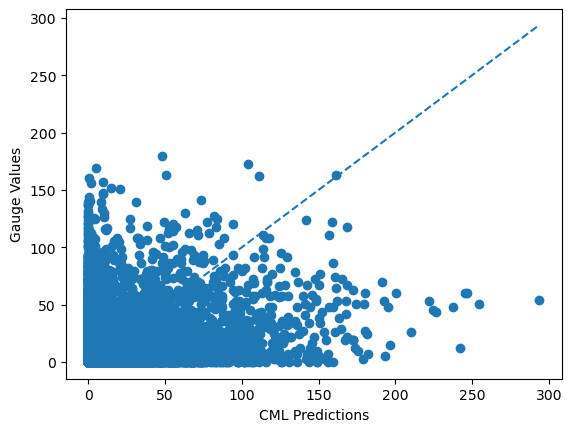

In [32]:
raingauge_df_5mins = raingauge_df.mul(12)
raingauge_df_15mins = raingauge_df_5mins.resample("15min").first()
station_dict = get_gauge_coordinate_mappings()
raingauge_choice = raingauge_df_15mins

global_gauge_values = []
global_cml_predictions = []

# global_gauge_values = np.zeros(shape=[raingauge_choice.shape[0], len(station_dict)])
# global_cml_predictions = np.zeros(shape=[raingauge_choice.shape[0], len(station_dict)])

for idx, (timestamp, row_data) in enumerate(raingauge_df_15mins.iterrows()):

  #We ignore nan values when performing correlation
  stations = [station for station in list(row_data.keys()) if not math.isnan(row_data[station])]
  try:

    R_grid = idw_interpolator(
        x=cmls_R_15min.lon_center, 
        y=cmls_R_15min.lat_center, 
        z=cmls_R_15min.R.sel(station='Station A').sel(time=timestamp.to_datetime64()), 
        xgrid=xgrid,
        ygrid=ygrid,
        resolution=0.01,
    )
  except KeyError:
    continue
  
  row_gauge_values = []
  row_pred_values = []
  for station in stations:
    lat, lon = station_dict[station]
    x_offset = math.floor((lon - xcoords[0]) / 0.01)
    y_offset = math.floor((ycoords[0] - lat) / 0.01)
    predicted_Z = R_grid[y_offset][x_offset] 
    if not np.isnan(predicted_Z):
      row_gauge_values.append(row_data[station])
      row_pred_values.append(predicted_Z)

  global_gauge_values.extend(row_gauge_values)
  global_cml_predictions.extend(row_pred_values)

global_cml_predictions = np.array(global_cml_predictions)
global_gauge_values=np.array(global_gauge_values)


pearson_r_global, pearson_p_global = pearsonr(global_gauge_values.flatten(), global_cml_predictions.flatten())
spearman_r_global, spearman_p_global = spearmanr(global_gauge_values.flatten(), global_cml_predictions.flatten())

#scatter plot of predicted vs actual values
plt.scatter(global_cml_predictions, global_gauge_values)
plot_bound = max(np.max(global_gauge_values.flatten()).astype(int),np.max(global_cml_predictions.flatten()).astype(int))
plt.plot(np.linspace(0,plot_bound,100),
        np.linspace(0,plot_bound,100), linestyle='--')

plt.xlabel("CML Predictions")
plt.ylabel("Gauge Values")


print(f"Pearson correlaton: {pearson_r_global}")
print(f"Spearman correlation: {spearman_r_global}")


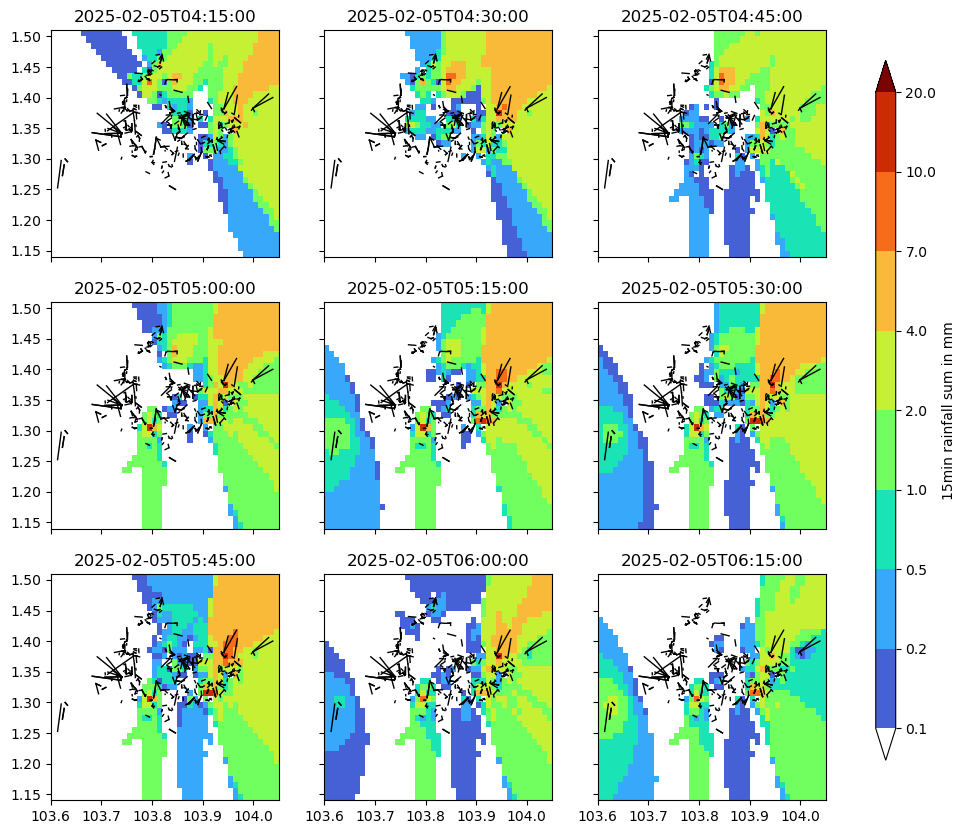

In [30]:
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(10, 10))

bounds = [0.1, 0.2, 0.5, 1, 2, 4, 7, 10, 20] 
norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')
cmap = plt.get_cmap('turbo').copy()
cmap.set_under('w')


for i, axi in enumerate(ax.flat):
    R_grid = idw_interpolator(
        x=cmls_R_15min.lon_center, 
        y=cmls_R_15min.lat_center, 
        z=cmls_R_15min.R.sel(station='Station A').isel(time=i + 400).where(ds_cmls.wet_fraction < 0.3), 
        xgrid=xgrid,
        ygrid=ygrid,
        resolution=0.01,
    )
    pc = axi.pcolormesh(
        idw_interpolator.xgrid, 
        idw_interpolator.ygrid, 
        R_grid, 
        shading='nearest', 
        cmap=cmap,
        norm=norm,
    )
    axi.set_title(str(cmls_R_15min.time.values[i + 400])[:19])
    plot_cml_lines(cmls_R_15min, ax=axi)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cb = fig.colorbar(pc, cax=cbar_ax, label='15min rainfall sum in mm', )